In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.cluster import MiniBatchKMeans
from scipy.spatial.distance import cdist
from time import time
from random import choices
from numpy.linalg import norm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
folders = [
    "heart_rate",
    "labels",
    "motion",
    "steps"
]

def calculate_intra_cluster_distance(segments, labels, centroids):
    distances = []
    for i, center in enumerate(centroids):
        cluster_points = segments[labels == i]
        if len(cluster_points) > 0:
            intra_distance = np.mean(np.linalg.norm(cluster_points - center, axis=1))
            distances.append(intra_distance)
        else:
            distances.append(0)
    return distances

def get_clustered_profiles(T, m, num_clusters, selection_method="medoid", num_nearest=3):
    segments = np.array([T[i: i + m] for i in range(len(T) - m + 1)])
    kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=0).fit(segments)
    centroids = kmeans.cluster_centers_
    labels = kmeans.labels_

    closest_snippets = []
    for center_idx, center in enumerate(centroids):
        cluster_indices = np.where(labels == center_idx)[0]
        distances = np.linalg.norm(segments[cluster_indices] - center, axis=1)

        if selection_method == "medoid":
            closest_snippet_idx = cluster_indices[np.argmin(distances)]
        elif selection_method == "mean":
            nearest_indices = cluster_indices[np.argsort(distances)[:num_nearest]]
            closest_snippet_idx = cluster_indices[int(np.mean(nearest_indices))]
        elif selection_method == "mode":
            from scipy.stats import mode
            closest_snippet_idx = mode(cluster_indices).mode[0]

        closest_snippets.append(closest_snippet_idx)

    # Distance matrix between centroids
    D = cdist(centroids, centroids)
    intra_cluster_distances = calculate_intra_cluster_distance(segments, labels, centroids)

    return D, labels, closest_snippets, intra_cluster_distances

def evaluate_clusters(df, series_col, subseq_size, k_values, cluster_range, base_path, selection_method="medoid", num_nearest=3):
    ts = df[series_col].values.astype(float)

    results = []
    for num_clusters in cluster_range:
        D, labels, closest_snippets, intra_distances = get_clustered_profiles(
            ts, subseq_size, num_clusters, selection_method=selection_method, num_nearest=num_nearest
        )
        snippets, snippet_profiles, areas = [], [], []
        Q = np.full((1, D.shape[1]), np.inf)

        for _ in range(k_values):
            minimum_area = np.inf
            index_min = -1

            for i in range(D.shape[0]):
                profile_area = np.sum(np.minimum(D[i, :], Q))
                if profile_area < minimum_area:
                    minimum_area = profile_area
                    index_min = i

            if index_min == -1:
                break

            Q = np.minimum(D[index_min, :], Q)
            representative_idx = closest_snippets[index_min]
            snippets.append((representative_idx, minimum_area))
            snippet_profiles.append(D[index_min, :])
            areas.append(minimum_area)

        total_area = sum(areas)
        fractions = [area / total_area for area in areas]

        results.append({
            "num_clusters": num_clusters,
            "snippets": snippets,
            "mean_distance": np.mean(intra_distances),
            "min_distance": np.min(intra_distances),
            "max_distance": np.max(intra_distances),
            "fractions": fractions,
            "areas": areas,
        })

        # Save snippets for each cluster configuration
        os.makedirs(base_path, exist_ok=True)
        for idx, snippet in enumerate(snippets):
            np.save(
                os.path.join(base_path, f"snippet_{num_clusters}_clusters_{idx}.npy"),
                ts[snippet[0]:snippet[0] + subseq_size]
            )

    return results

In [25]:
base_path = '/home/gui/SnippetFinder/time_cuts'
for dataframe in os.listdir(base_path):
    if dataframe.endswith(".csv"):
        sleep_df = pd.read_csv(f'{base_path}/{dataframe}')
        sleep_df['HEART_RATE(bpm)'].replace(0.0, np.nan, inplace=True)
        sleep_df.dropna(subset=['HEART_RATE(bpm)'], inplace=True)
        sleep_df = sleep_df[['timestamp', 'ACC_X(m/s^2)', 'ACC_Y', 'ACC_Z', 'STEP_COUNT', 'HEART_RATE(bpm)']]
        sleep_df.rename(columns={'timestamp': 'time', 'ACC_X(m/s^2)': 'x', 'ACC_Y': 'y', 'ACC_Z': 'z', 'STEP_COUNT': 'steps', 'HEART_RATE(bpm)': 'bpm'}, inplace=True)

        # Generate random sleep stages
        poss = ["N1", "N2", "N3", 4, "REM"]
        states = choices(poss, k=len(sleep_df.index))
        sleep_df['stage'] = states

        df_dict = {}

        for folder in folders:
            if folder == 'motion':
                df_dict[folder] = sleep_df[['time', 'x', 'y', 'z']]
            elif folder == 'heart_rate':
                df_dict[folder] = sleep_df[['time', 'bpm']]
            elif folder == 'steps':
                df_dict[folder] = sleep_df[['time', 'steps']]
            elif folder == 'labels':
                df_dict[folder] = sleep_df[['time', 'stage']]

        polygraph_end_time = df_dict["labels"].time.max()
        for folder in df_dict:
            folder_df = df_dict[folder]
            df_dict[folder] = folder_df[folder_df.time <= polygraph_end_time]
            

        save_path = f"/home/gui/SnippetFinder/cluster_eval/saves_bpm/{dataframe.replace('.csv', '')}"
        subseq_size = 420
        cluster_range = range(2, 16)  # Number of clusters to evaluate
        k_values = 3

        results = evaluate_clusters(
            df_dict['heart_rate'],
            series_col='bpm',
            subseq_size=subseq_size,
            k_values=k_values,
            cluster_range=cluster_range,
            base_path=save_path
        )

        # Save results summary
        results_df = pd.DataFrame(results)
        results_df.to_csv(os.path.join(save_path, "cluster_evaluation_summary_bpm.csv"), index=False)

        # Generate plot
        plt.figure(figsize=(12, 6))
        plt.plot(results_df["num_clusters"], results_df["mean_distance"], marker='o', label="Mean Distance", color='blue')
        plt.errorbar(
            results_df["num_clusters"],
            results_df["mean_distance"],
            yerr=[
                results_df["mean_distance"] - results_df["min_distance"],
                results_df["max_distance"] - results_df["mean_distance"],
            ],
            fmt='o',
            ecolor='gray',
            alpha=0.5,
            label="Min-Max Range"
        )
        plt.title(f"Intra-Cluster Distance Metrics for {dataframe}")
        plt.xlabel("Number of Clusters")
        plt.ylabel("Intra-Cluster Distance")
        plt.legend()
        plt.grid()
        plt.savefig(os.path.join(save_path, f"{dataframe.replace('.csv', '')}_intra_cluster_distances_bpm.png"))
        plt.close()
        
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=- BPM ^ - MOTION v=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-

        df_dict["motion"]["magnitude"] = df_dict["motion"][["x","y","z"]].apply(lambda x: norm(x.values), axis=1)
        save_path = f"/home/gui/SnippetFinder/cluster_eval/saves_motion/{dataframe.replace('.csv', '')}"
        subseq_size = 420
        cluster_range = range(2, 16)  # Number of clusters to evaluate
        k_values = 3

        results = evaluate_clusters(
            df_dict['motion'],
            series_col='magnitude',
            subseq_size=subseq_size,
            k_values=k_values,
            cluster_range=cluster_range,
            base_path=save_path
        )

        # Save results summary
        results_df = pd.DataFrame(results)
        results_df.to_csv(os.path.join(save_path, "cluster_evaluation_summary_motion.csv"), index=False)

        # Generate plot
        plt.figure(figsize=(12, 6))
        plt.plot(results_df["num_clusters"], results_df["mean_distance"], marker='o', label="Mean Distance", color='blue')
        plt.errorbar(
            results_df["num_clusters"],
            results_df["mean_distance"],
            yerr=[
                results_df["mean_distance"] - results_df["min_distance"],
                results_df["max_distance"] - results_df["mean_distance"],
            ],
            fmt='o',
            ecolor='gray',
            alpha=0.5,
            label="Min-Max Range"
        )
        plt.title(f"Intra-Cluster Distance Metrics for {dataframe}")
        plt.xlabel("Number of Clusters")
        plt.ylabel("Intra-Cluster Distance")
        plt.legend()
        plt.grid()
        plt.savefig(os.path.join(save_path, f"{dataframe.replace('.csv', '')}_intra_cluster_distances_motion.png"))
        plt.close()

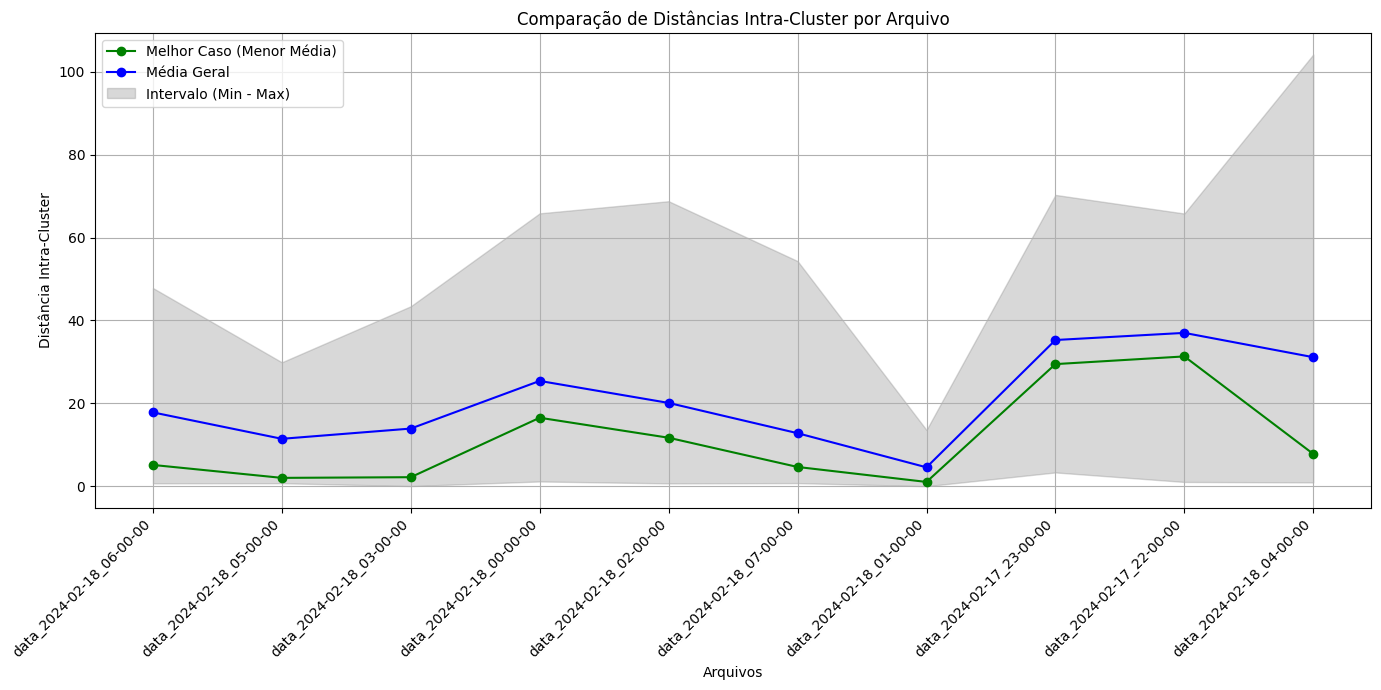

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Diretório onde estão os resultados salvos
results_dir = '/home/gui/SnippetFinder/cluster_eval/saves_motion'

# Lista para armazenar os resultados de cada arquivo
summary_data = []

for folder in os.listdir(results_dir):
    folder_path = os.path.join(results_dir, folder)
    if os.path.isdir(folder_path):  # Verifica se é um diretório
        summary_file = os.path.join(folder_path, "cluster_evaluation_summary_motion.csv")
        if os.path.exists(summary_file):
            # Carrega o resumo dos resultados
            df = pd.read_csv(summary_file)
            
            # Encontra o melhor caso (menor distância média intra-cluster)
            best_case = df.loc[df["mean_distance"].idxmin()]
            
            # Adiciona os dados ao resumo geral
            summary_data.append({
                "file": folder,
                "best_num_clusters": best_case["num_clusters"],
                "best_mean_distance": best_case["mean_distance"],
                "overall_mean": df["mean_distance"].mean(),
                "overall_min": df["min_distance"].min(),
                "overall_max": df["max_distance"].max(),
            })

# Converte os dados resumidos em um DataFrame
summary_df = pd.DataFrame(summary_data)


# Geração do Gráfico Comparativo
plt.figure(figsize=(14, 7))
x_labels = summary_df["file"]

# Gráficos dos valores
plt.plot(x_labels, summary_df["best_mean_distance"], marker='o', label="Melhor Caso (Menor Média)", color='green')
plt.plot(x_labels, summary_df["overall_mean"], marker='o', label="Média Geral", color='blue')
plt.fill_between(
    x_labels,
    summary_df["overall_min"],
    summary_df["overall_max"],
    color='gray',
    alpha=0.3,
    label="Intervalo (Min - Max)"
)

plt.xticks(rotation=45, ha='right')
plt.title("Comparação de Distâncias Intra-Cluster por Arquivo")
plt.ylabel("Distância Intra-Cluster")
plt.xlabel("Arquivos")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
